In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.utils import shuffle
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch.optim as optim

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [3]:
GLOVE_DIR="../pre-trained-embdedding-models/glove.6B/"
dimension=100
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

## PyTorch Dataset and Model

In [4]:
class dedupDataset(Dataset):
    """User defined class to build a dataset using Pytorch class Dataset."""
    
    def __init__(self, data, encoding, transform = None):
        """Method to initilaize variables.""" 
        self.data = data
        self.encoding = encoding

        self.transform=transform

    def __getitem__(self, index):
        w1, w2, isDuplicate = self.data.loc[index]
        
        e1 = self.encoding[w1.lower().strip()]
        e2 = self.encoding[w2.lower().strip()]

        E = torch.cat((torch.tensor(e1),torch.tensor(e2)))        

        if self.transform is not None:
            E = self.transform(E)

        return E, torch.tensor(isDuplicate).float()

    def __len__(self):
        return len(self.data)

In [5]:
class NN(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.fc1 = nn.Linear(d*2, 100)
        self.fc2 = nn.Linear(100, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

## Data Preparation
### Remove all data with entries which do not have embeddings

 Next work -  doc2vec/train word2vec

In [6]:
data_path = "../data/dedup-data-6187_37728.csv"

df = pd.read_csv(data_path, usecols=['w1', 'w2', 'isDuplicate']).sample(frac=1).reset_index(drop=True)

In [7]:
df['w1_has_embedding']=df['w1'].apply(lambda x:x.lower().strip() in embeddings_index)
df['w2_has_embedding']=df['w2'].apply(lambda x:x.lower().strip() in embeddings_index)

In [8]:
df=df[df['w1_has_embedding']==True]
df=df[df['w2_has_embedding']==True]

df = df.drop(['w1_has_embedding', 'w2_has_embedding'], axis=1)
df = df.reset_index(drop=True)

In [9]:
df_train=df[:int(0.7*len(df))].reset_index(drop=True)
df_test =df[int(0.7*len(df)):].reset_index(drop=True)

In [10]:
df_train['isDuplicate'].value_counts()

0.0    6834
1.0    1067
Name: isDuplicate, dtype: int64

# Train pytorch NN

In [11]:
model = NN(d=dimension).to(device)

In [12]:
train_set, test_set = dedupDataset(df_train, embeddings_index), dedupDataset(df_test, embeddings_index)
train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=len(df_test))


In [13]:
# create your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

In [14]:
def binary_acc(y_pred, y_ground):

    # print(y_pred, y_ground)  
    y_pred_tag = torch.round(y_pred)
    # print(y_pred_tag, y_ground)  


    correct_results_sum = (y_pred_tag == y_ground).sum().float()
    # print(correct_results_sum)
    acc = correct_results_sum/y_ground.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
epochs=75
#forward loop
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(train_loader):
    x_train,y_train = x_train.to(device), y_train.to(device)
    #calculate output
    output = model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
    
    acc = binary_acc(output, y_train.reshape(-1,1))
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%5 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

/home/sohampachpande/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0	loss : 0.5500394105911255	 accuracy : 100.0
epoch 5	loss : 0.02996617928147316	 accuracy : 100.0
epoch 10	loss : 0.007554203271865845	 accuracy : 100.0
epoch 15	loss : 0.002845935756340623	 accuracy : 100.0
epoch 20	loss : 0.0011203004978597164	 accuracy : 100.0
epoch 25	loss : 0.0004122510727029294	 accuracy : 100.0
epoch 30	loss : 0.00013626550207845867	 accuracy : 100.0
epoch 35	loss : 4.339312363299541e-05	 accuracy : 100.0
epoch 40	loss : 1.3828373084834311e-05	 accuracy : 100.0
epoch 45	loss : 4.5895681068941485e-06	 accuracy : 100.0
epoch 50	loss : 1.4901172562531428e-06	 accuracy : 100.0
epoch 55	loss : 4.768372718899627e-07	 accuracy : 100.0
epoch 60	loss : 1.1920928955078125e-07	 accuracy : 100.0
epoch 65	loss : 5.960464477539063e-08	 accuracy : 100.0
epoch 70	loss : 0.0	 accuracy : 100.0


In [26]:
y_truth_list = []
y_pred_list = []
model.eval()
with torch.no_grad():
  for j,(x_test,y_test) in enumerate(test_loader):
      x_test,y_test = x_test.to(device), y_test.to(device)
      #calculate output
      output = model(x_test)
  
      acc = binary_acc(output, y_test.reshape(-1,1))



/home/sohampachpande/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [27]:
acc

tensor(98.)

In [28]:
y_pred = torch.round(output.reshape(-1))

In [29]:
y_pred_arr = np.asarray(y_pred.cpu())
y_test_arr = np.asarray(y_test.cpu())

In [30]:
from sklearn.metrics import roc_curve, classification_report

In [31]:
print(classification_report(y_test_arr, y_pred_arr))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2941
         1.0       0.94      0.93      0.94       446

    accuracy                           0.98      3387
   macro avg       0.97      0.96      0.96      3387
weighted avg       0.98      0.98      0.98      3387



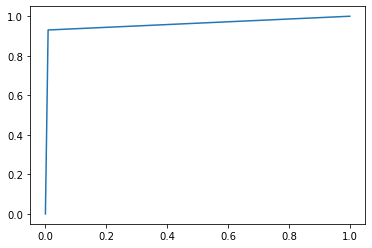

In [32]:
fpr, tpr, thresholds = roc_curve(y_test_arr, y_pred_arr)
plt.plot(fpr,tpr)
plt.show()

In [33]:
print(model)

NN(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [34]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def makeCFwithStats(y_pred, y_truth):
    cf = confusion_matrix(y_truth, y_pred)
    accuracy  = np.trace(cf) / float(np.sum(cf))
    precision = cf[1,1] / sum(cf[:,1])
    recall    = cf[1,1] / sum(cf[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

    df_cm = pd.DataFrame(cf, index = ["Not Duplicate", "Duplicate"],
                    columns = ["Not Duplicate", "Duplicate"])
    plt.figure(figsize = (6,5))
    sn.heatmap(df_cm/np.sum(cf), annot=True, fmt='.2%')
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label' + stats_text, fontsize=14)
    plt.show()

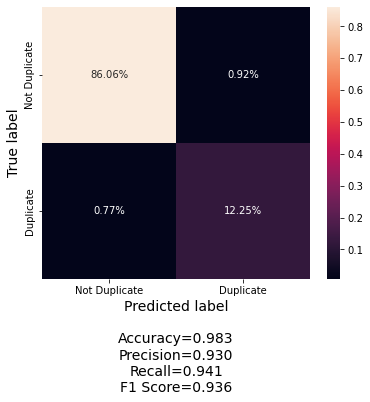

In [35]:
makeCFwithStats(y_test_arr, y_pred_arr)